## Test modules during dev


In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes

2024-09-30 19:41:40.228144: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 19:41:40.228179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 19:41:40.230079: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
#dtree = datasets.read_filtered_datatree()
#dtree = datasets.calculate_magnitudes(dtree)

In [53]:
# We need one place to save all the experiment relevant info.  
experiment_config= {'simulation_names':['P2L'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':3, 
                    'all_ml_variables' : ['dudx_widened',  
                                          'dvdx_widened', 
                                          'dudy_widened',
                                          'dvdy_widened',
                                          'dhdx_widened',
                                          'dhdy_widened',
                                          'filter_scale', 
                                          'uphp',
                                          'vphp'], 
                    
                    'input_channels' : ['dudx_widened',  
                                          'dvdx_widened', 
                                          'dudy_widened',
                                          'dvdy_widened',
                                          'dhdx_widened',
                                          'dhdy_widened',
                                          'filter_scale'],
                    
                    'output_channels' : ['uphp',
                                          'vphp'],
                    'coeff_channels'  : [], 
        
                    'train_time_range': slice(0, 640),
                    'test_time_range' : slice(-64, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    'num_inputs': 55, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt'
                    
            }

## Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [7]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'])

In [8]:
DT.simulation_data

DataTree('None', parent=None)
└── DataTree('P2L')
    ├── DataTree('50')
    │       Dimensions:                      (Time: 7200, xh: 150, yh: 200, zl: 2, Xn: 3,
    │                                         Yn: 3, zi: 3)
    │       Coordinates:
    │         * Time                         (Time) object 58kB 0001-01-11 00:00:00 ... 0...
    │         * xh                           (xh) float64 1kB 4.0 12.0 ... 1.196e+03
    │         * yh                           (yh) float64 2kB 4.0 12.0 ... 1.596e+03
    │         * zl                           (zl) float64 16B 1.031e+03 1.033e+03
    │         * zi                           (zi) float64 24B 1.03e+03 1.032e+03 1.034e+03
    │       Dimensions without coordinates: Xn, Yn
    │       Data variables: (12/40)
    │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           ...                           ...
    │           dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           dhdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 31GB dask.array<chunksize=(36, 2, 199, 149, 3, 3), meta=np.ndarray>
    │           uphp_rotated_nondim          (Time, zl, yh, xh) float64 3GB dask.array<chunksize=(36, 2, 199, 149), meta=np.ndarray>
    │           vphp_rotated_nondim          (Time, zl, yh, xh) float64 3GB dask.array<chunksize=(36, 2, 199, 149), meta=np.ndarray>
    │       Attributes:
    │           simulation_name:  P2L
    │           filter_scale:     50
    │           source:           gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/r...
    │           description:      Dataset for P2L experiment at 50 km resolution
    ├── DataTree('100')
    │       Dimensions:                      (Time: 7200, xh: 60, yh: 80, zl: 2, Xn: 3,
    │                                         Yn: 3, zi: 3)
    │       Coordinates:
    │         * Time                         (Time) object 58kB 0001-01-11 00:00:00 ... 0...
    │         * xh                           (xh) float64 480B 10.0 30.0 ... 1.19e+03
    │         * yh                           (yh) float64 640B 10.0 30.0 ... 1.59e+03
    │         * zl                           (zl) float64 16B 1.031e+03 1.033e+03
    │         * zi                           (zi) float64 24B 1.03e+03 1.032e+03 1.034e+03
    │       Dimensions without coordinates: Xn, Yn
    │       Data variables: (12/40)
    │           dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(36, 2, 79, 59, 3, 3), meta=np.ndarray>
    │           dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(36, 2, 79, 59, 3, 3), meta=np.ndarray>
    │           dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 5GB dask.array<chunksize=(36, 2, 79, 59, 3, 3), meta=np.ndarray>
   

## ML data
Go from simulation data to batches. 
In this step things like dropping extra points, masking of data etc happen. 

In [9]:
ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

Will load : 0.85888 gb into memory.
load took: 23.1902 seconds


In [10]:
ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])


Will load : 0.085888 gb into memory.
load took: 3.0981 seconds


In [11]:
len(ML_DT_train.ml_batches), len(ML_DT_test.ml_batches) 

(37, 5)

### Convert these xbatcher batches to processed ones for training

This needs to take care of extra dims, like Xn,Yn.

In [12]:
import jax.numpy as jnp

In [13]:
batch_xr = ML_DT_train.ml_batches[0]

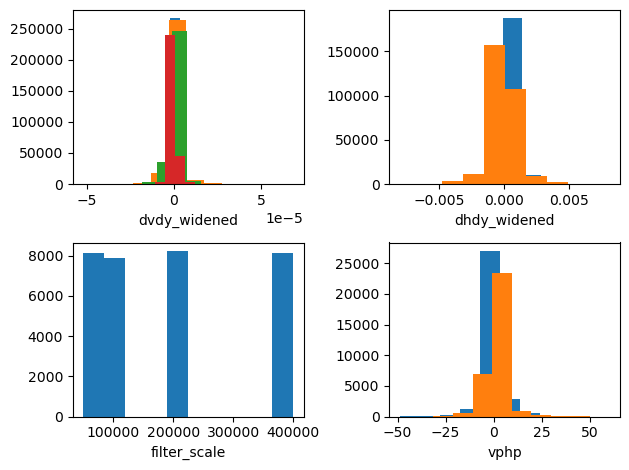

In [14]:
plt.subplot(221)
batch_xr[experiment_config['input_channels'][0]].plot.hist();
batch_xr[experiment_config['input_channels'][1]].plot.hist();
batch_xr[experiment_config['input_channels'][2]].plot.hist();
batch_xr[experiment_config['input_channels'][3]].plot.hist();

plt.subplot(222)
batch_xr[experiment_config['input_channels'][4]].plot.hist();
batch_xr[experiment_config['input_channels'][5]].plot.hist();

plt.subplot(223)
batch_xr[experiment_config['input_channels'][6]].plot.hist();

plt.subplot(224)
batch_xr.uphp.plot.hist();
batch_xr.vphp.plot.hist();

plt.tight_layout()

In [15]:
# Define the variables and assign normalizations 
normalize_data_dic = {
    'dudx': ([], 1e-6),  # scalar value
    'dvdx': ([], 1e-6),
    'dudy': ([], 1e-6),
    'dvdy': ([], 1e-6),
    'dhdx': ([], 1e-3),
    'dhdy': ([], 1e-3),
    'filter_scale': ([], 140e3),
    'uphp': ([], 4.),
    'vphp': ([], 4.),
    'dudx_widened': ([], 1e-6),  # scalar value
    'dvdx_widened': ([], 1e-6),
    'dudy_widened': ([], 1e-6),
    'dvdy_widened': ([], 1e-6),
    'dhdx_widened': ([], 1e-3),
    'dhdy_widened': ([], 1e-3),
}

ds_norm = xr.Dataset(normalize_data_dic)

In [16]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      ds_norm=ds_norm)

In [17]:
test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      ds_norm=ds_norm)

In [18]:
ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [19]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (32380, 55)
Output (y) batch shape: (32380, 2)


## The ML part


In [20]:
num_in = batch_out['X'].shape[-1]
num_in

55

In [21]:
ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = experiment_config['network_shape']) 

In [22]:
ANN_model.count_parameters()

3422


In [23]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model)

In [24]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=21, print_freq=2)

At epoch 1. Train loss :  1.1349280975960396 , Test loss: 0.7098261475563049
At epoch 3. Train loss :  0.43617570239144404 , Test loss: 0.3611744463443756
At epoch 5. Train loss :  0.3139389560029313 , Test loss: 0.27052121758461
At epoch 7. Train loss :  0.26257899282751856 , Test loss: 0.22698159217834474
At epoch 9. Train loss :  0.22449533439971306 , Test loss: 0.20968765914440154
At epoch 11. Train loss :  0.20218308632438248 , Test loss: 0.18176516592502595
At epoch 13. Train loss :  0.1931102565816931 , Test loss: 0.1920503705739975
At epoch 15. Train loss :  0.18113713570543238 , Test loss: 0.17491863071918487
At epoch 17. Train loss :  0.17412686347961426 , Test loss: 0.16734208762645722
At epoch 19. Train loss :  0.16751497661745227 , Test loss: 0.15783033967018129
At epoch 21. Train loss :  0.1607730251711768 , Test loss: 0.15325431227684022
CPU times: user 1min 7s, sys: 2.04 s, total: 1min 9s
Wall time: 42.9 s


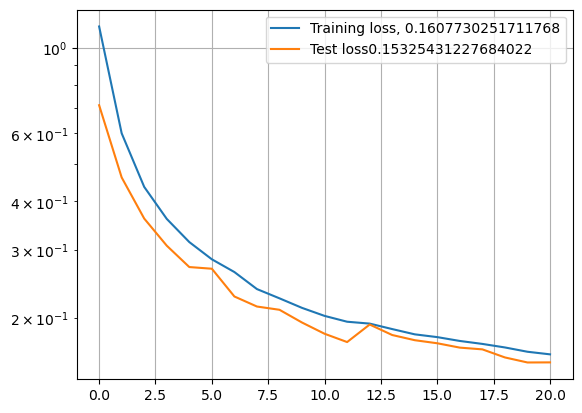

In [25]:
## Loss plot
plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

plt.grid()
plt.yscale('log')
plt.legend()

In [54]:
regress_sys.save_checkpoint(experiment_config['exp_ckpt_save_dir'])

In [55]:
regress_sys.state

TrainState(step=777, apply_fn=<bound method Module.apply of ArtificialNeuralNetwork(
    # attributes
    features = [36, 36, 2]
    bias = True
)>, params={'params': {'layers_0': {'bias': Array([ 2.0899496 , -0.4660215 , -0.45472482, -0.20357051,  0.89856714,
        1.3025671 , -0.5428454 ,  0.6436175 , -0.506792  ,  0.09814488,
        0.21250498,  0.54369974,  0.8408391 , -0.6920158 , -0.17890292,
       -0.3932388 ,  0.383585  ,  0.91402966, -0.11028731, -0.66941947,
        0.7011228 ,  0.38367406,  1.3834777 , -0.43887192, -1.0750167 ,
        2.3748963 , -0.6678699 ,  0.2965776 ,  0.08048886,  1.0739293 ,
        0.86368984, -0.63852245, -0.3186644 , -0.46230614,  2.0582404 ,
       -0.7970688 ], dtype=float32), 'kernel': Array([[-0.08337545, -0.12979141,  0.09145276, ..., -0.08077861,
        -0.07145293,  0.12279961],
       [-0.1052553 ,  0.0181971 , -0.20972055, ...,  0.14725976,
         0.1779013 , -0.12585819],
       [-0.01858069,  0.03104494,  0.05130389, ...,  0.03250

In [56]:
new_regress_sys =  ML_classes.AnnRegressionSystem(ANN_model)

In [57]:
new_regress_sys.read_checkpoint(experiment_config['exp_ckpt_save_dir'])

In [58]:
new_regress_sys.state

TrainState(step=777, apply_fn=<bound method Module.apply of ArtificialNeuralNetwork(
    # attributes
    features = [36, 36, 2]
    bias = True
)>, params={'params': {'layers_0': {'bias': array([ 2.0899496 , -0.4660215 , -0.45472482, -0.20357051,  0.89856714,
        1.3025671 , -0.5428454 ,  0.6436175 , -0.506792  ,  0.09814488,
        0.21250498,  0.54369974,  0.8408391 , -0.6920158 , -0.17890292,
       -0.3932388 ,  0.383585  ,  0.91402966, -0.11028731, -0.66941947,
        0.7011228 ,  0.38367406,  1.3834777 , -0.43887192, -1.0750167 ,
        2.3748963 , -0.6678699 ,  0.2965776 ,  0.08048886,  1.0739293 ,
        0.86368984, -0.63852245, -0.3186644 , -0.46230614,  2.0582404 ,
       -0.7970688 ], dtype=float32), 'kernel': array([[-0.08337545, -0.12979141,  0.09145276, ..., -0.08077861,
        -0.07145293,  0.12279961],
       [-0.1052553 ,  0.0181971 , -0.20972055, ...,  0.14725976,
         0.1779013 , -0.12585819],
       [-0.01858069,  0.03104494,  0.05130389, ...,  0.03250

Testing around saving check points 

In [26]:
import orbax.checkpoint
import shutil
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'


import numpy as np
import jax
from jax import random, numpy as jnp

import flax
from flax import linen as nn
from flax.training import checkpoints, train_state
from flax import struct, serialization
import orbax.checkpoint

import optax

In [27]:
# what all we might want to save in a check point. 

# state 
# training, testing loss
# Epoch number

# Things referencing the experiment (config dictionary) will be saved somewhere else. 

ckpt_dir = '/home/jovyan/mesoscale_buoyancy_param_ML/module_dev_notebooks/flax_ckpt'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir) 

In [28]:
# A simple model with one linear layer.
key1, key2 = random.split(random.key(0))
x1 = random.normal(key1, (5,))      # A simple JAX array.
model = nn.Dense(features=3)
variables = model.init(key2, x1)

# Flax's TrainState is a pytree dataclass and is supported in checkpointing.
# Define your class with `@flax.struct.dataclass` decorator to make it compatible.
tx = optax.sgd(learning_rate=0.001)      # An Optax SGD optimizer.
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=variables['params'],
    tx=tx)
# Perform a simple gradient update similar to the one during a normal training workflow.
state = state.apply_gradients(grads=jax.tree_util.tree_map(jnp.ones_like, state.params))

# Some arbitrary nested pytree with a dictionary and a NumPy array.
config = {'dimensions': np.array([5, 3])}

# Bundle everything together.
ckpt = {'model': state, 'config': config, 'data': [x1]}
ckpt

{'model': TrainState(step=1, apply_fn=<bound method Module.apply of Dense(
     # attributes
     features = 3
     use_bias = True
     dtype = None
     param_dtype = float32
     precision = None
     kernel_init = init
     bias_init = zeros
     dot_general = None
     dot_general_cls = None
 )>, params={'bias': Array([-0.001, -0.001, -0.001], dtype=float32), 'kernel': Array([[ 0.26048955, -0.61399287, -0.23458514],
        [ 0.11050402, -0.8765793 ,  0.9800635 ],
        [ 0.36260957,  0.18276349, -0.6856061 ],
        [-0.8519373 , -0.6416717 , -0.4818122 ],
        [-0.6886102 , -0.33987316, -0.05898903]], dtype=float32)}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7bdd3a0ac5e0>, update=<function chain.<locals>.update_fn at 0x7bdd3a0ac0e0>), opt_state=(EmptyState(), EmptyState())),
 'config': {'dimensions': array([5, 3])},
 'data': [Array([0.59902626, 0.2172144 , 2.4202902 , 0.03266738, 1.2164948 ],      dtype=float32)]}

In [30]:
from flax.training import orbax_utils

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save(ckpt_dir+'/single', ckpt, save_args=save_args,)

In [33]:
options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=2, create=True)
checkpoint_manager = orbax.checkpoint.CheckpointManager(
                     ckpt_dir+'/managed', orbax_checkpointer, options)

# Inside a training loop
for step in range(5):
    # ... do your training
    checkpoint_manager.save(step, ckpt, save_kwargs={'save_args': save_args})

os.listdir(ckpt_dir+'/managed')  # Because max_to_keep=2, only step 3 and 4 are retained

['4', '3']

In [41]:
raw_restored = orbax_checkpointer.restore(ckpt_dir+'/single', item='model')
raw_restored

{'config': {'dimensions': array([5, 3])},
 'data': [array([0.59902626, 0.2172144 , 2.4202902 , 0.03266738, 1.2164948 ],
        dtype=float32)],
 'model': {'opt_state': [None, None],
  'params': {'bias': array([-0.001, -0.001, -0.001], dtype=float32),
   'kernel': array([[ 0.26048955, -0.61399287, -0.23458514],
          [ 0.11050402, -0.8765793 ,  0.9800635 ],
          [ 0.36260957,  0.18276349, -0.6856061 ],
          [-0.8519373 , -0.6416717 , -0.4818122 ],
          [-0.6886102 , -0.33987316, -0.05898903]], dtype=float32)},
  'step': 1}}

In [39]:
empty_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=jax.tree_util.tree_map(np.zeros_like, variables['params']),  # values of the tree leaf doesn't matter
    tx=tx,
)
empty_config = {'dimensions': np.array([0,0,0,0])}
target = {'model': empty_state, 'config': empty_config, 'data': [jnp.zeros_like(x1)]}


state_restored = orbax_checkpointer.restore(ckpt_dir+'/single', item=target)
state_restored

{'config': {'dimensions': array([5, 3])},
 'data': [array([0.59902626, 0.2172144 , 2.4202902 , 0.03266738, 1.2164948 ],
        dtype=float32)],
 'model': TrainState(step=1, apply_fn=<bound method Module.apply of Dense(
     # attributes
     features = 3
     use_bias = True
     dtype = None
     param_dtype = float32
     precision = None
     kernel_init = init
     bias_init = zeros
     dot_general = None
     dot_general_cls = None
 )>, params={'bias': array([-0.001, -0.001, -0.001], dtype=float32), 'kernel': array([[ 0.26048955, -0.61399287, -0.23458514],
        [ 0.11050402, -0.8765793 ,  0.9800635 ],
        [ 0.36260957,  0.18276349, -0.6856061 ],
        [-0.8519373 , -0.6416717 , -0.4818122 ],
        [-0.6886102 , -0.33987316, -0.05898903]], dtype=float32)}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7bdd3a0ac5e0>, update=<function chain.<locals>.update_fn at 0x7bdd3a0ac0e0>), opt_state=(EmptyState(), EmptyState()))}